In [2]:
%load_ext zipline

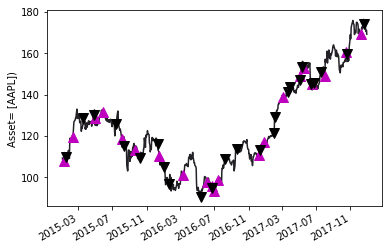

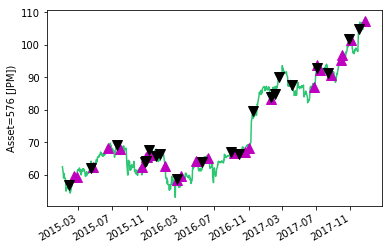

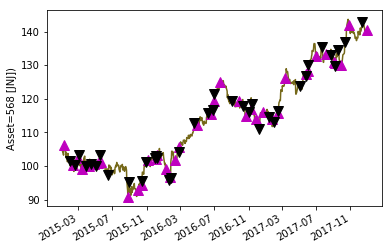

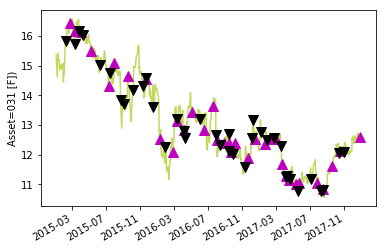

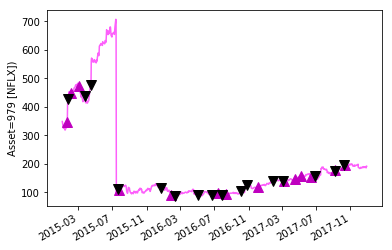

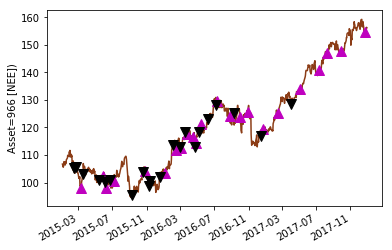

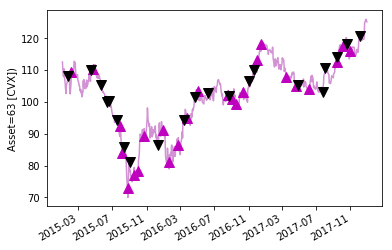

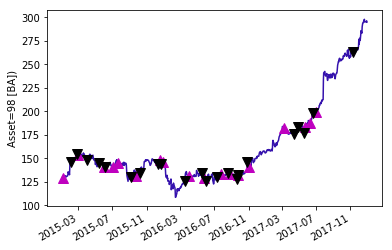

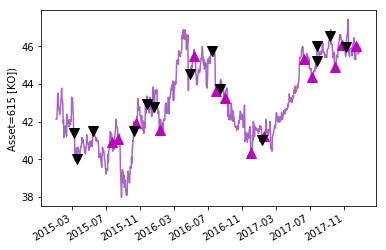

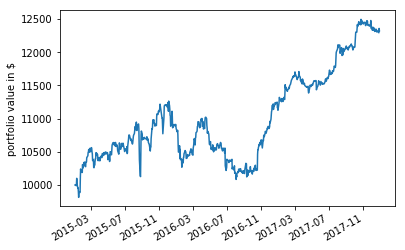

,Equity(8 [AAPL]),Equity(298 [BA]),Equity(763 [CVX]),Equity(1031 [F]),Equity(1568 [JNJ]),Equity(1576 [JPM]),Equity(1615 [KO]),Equity(1966 [NEE]),Equity(1979 [NFLX]),algo_volatility,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2015-01-02 21:00:00+00:00,109.330,129.949,112.58,15.36,104.52,62.49,42.14,106.69,348.940,NaN,...,0.00,0.00,0,NaN,10000.000000,0.000,0.000,1,[],0.0
2015-01-05 21:00:00+00:00,106.250,129.050,108.08,14.76,103.79,60.55,42.14,105.56,331.180,0.001748,...,0.00,0.00,0,-11.224972,10000.000000,0.000,0.000,2,"[{u'commission': None, u'amount': 8, u'sid': E...",0.0
2015-01-06 21:00:00+00:00,106.260,127.530,108.03,14.62,103.28,58.98,42.46,105.97,325.510,0.007194,...,0.00,0.00,0,-10.665082,6937.722640,3060.720,3060.720,3,[],0.0
2015-01-07 21:00:00+00:00,107.750,129.509,107.94,15.04,105.56,59.07,42.99,106.94,327.200,0.022645,...,0.00,0.00,0,12.960781,6937.722640,3052.210,3052.210,4,"[{u'commission': None, u'amount': 10, u'sid': ...",0.0
2015-01-08 21:00:00+00:00,111.890,131.800,110.41,15.42,106.39,60.39,43.51,107.59,334.455,0.062145,...,0.00,0.00,0,82.643065,5859.673890,4154.432,4154.432,5,"[{u'commission': None, u'amount': 10, u'sid': ...",0.0
2015-01-09 21:00:00+00:00,112.010,131.540,108.21,15.21,104.94,59.34,43.03,106.64,329.290,0.084530,...,0.00,0.00,0,1.863678,2581.354600,7519.470,7519.470,6,[],0.0
2015-01-12 21:00:00+00:00,109.250,130.870,105.88,15.22,104.58,58.83,42.64,106.37,318.830,0.088522,...,0.00,0.00,0,-2.642503,2581.354600,7440.560,7440.560,7,[],0.0
2015-01-13 21:00:00+00:00,110.220,131.170,104.20,15.21,104.76,58.84,42.63,106.79,323.790,0.082111,...,0.00,0.00,0,-2.340435,2581.354600,7371.880,7371.880,8,[],0.0
2015-01-14 21:00:00+00:00,109.800,130.380,103.90,15.11,104.00,56.81,42.56,107.45,324.240,0.081849,...,0.00,0.00,0,-4.523135,2581.354600,7374.310,7374.310,9,"[{u'commission': None, u'amount': -10, u'sid':...",0.0
2015-01-15 21:00:00+00:00,106.820,130.139,102.67,14.86,102.49,54.99,42.38,107.04,323.760,0.085362,...,0.00,0.00,0,-6.396364,3678.795600,6218.250,6218.250,10,[],0.0


In [111]:
%%zipline --start 2015-1-1 --end 2018-1-1  --capital-base 10000 -o ../data/ensemble1.pickle

'''
Ensemble Strategy on a combination of different Assets.
Pipelines are used to filter out assets that has bad indicators.
'''
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math
from zipline.finance import commission, slippage  
from zipline.api import (
    sid, 
    symbol,
    schedule_function, 
    date_rules, 
    time_rules,
    order_target_percent,
    record) 

import talib
from talib import EMA, BBANDS, RSI, ATR
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.api import attach_pipeline, pipeline_output
from zipline.pipeline.factors import (
    ExponentialWeightedMovingAverage, 
    AverageDollarVolume, 
    RSI, # weak indicator
    BollingerBands,
    #AnnualizedVolatility,
    #RollingLinearRegression,
    #RollingPearson, 
    MaxDrawdown,
    Returns,
    VWAP,
    TrueRange
)
    

def initialize(context):
    
    context.sectors = dict()
    context.sectors['Technology'] = [
        symbol('AAPL'),
        #symbol('GOOGL'),
        #symbol('NVDA'),
        #symbol('FB'), 
        #symbol('MSFT'),
    ]
    
    context.sectors['Financial'] = [
        symbol('JPM'),
        #symbol('BRK-A'),
        #symbol('BAC')
    ] 
    
    context.sectors['Healthcare'] =[
        symbol('JNJ'),
        #symbol('PFE'), 
        #symbol('UNH')
    ]    
    
    context.sectors['Service'] =[
        symbol('f'),  
        #symbol('WMT'), 
        symbol('NFLX')
    ]
    
    context.sectors['Utility'] =[
        symbol('NEE'),  
        #symbol('DUK'), 
        #symbol('SRE')
    ]
    
    context.sectors['BasicMaterial'] =[
        symbol('CVX'),
        #symbol('PSX'),
        #symbol('CEO') 
    ]
    
    context.sectors['IndustrialGoods'] =[
        symbol('BA'),
        #symbol('MMM'),
        #symbol('HON') 
    ]
    
    context.sectors['ConsumerGoods'] =[
        symbol('KO'),
        #symbol('PM'),
        #symbol('NKE')
    ]
    
    
    context.assets = \
    context.sectors['Technology'] + \
    context.sectors['Financial'] + \
    context.sectors['Healthcare'] + \
    context.sectors['Service'] + \
    context.sectors['Utility'] + \
    context.sectors['BasicMaterial'] + \
    context.sectors['IndustrialGoods'] + \
    context.sectors['ConsumerGoods']  
    
    
    context.pct_per_asset = 1.0 / len(context.assets)  
    strategies = [
        #getMaxDrawDownIndicator, #0
        getRsiIndicator,  #1
        getbbandIndicator,  #2
        getAtrIndicator,  #3
        getEMAIndicator,       #4
        #getMomentumIndicator,  #5
        #getVwmaIndicator  #6
    ]
    #context.strategies = strategies[1:2]
    context.strategies = strategies
    context.Hparameters = {
        'long_win':30, 
        'short_win':10, 
        'span':15,               #for exponential moving average factor
        'momentumDelta': 0.02,   #for momentum factor
        'delta': 0.005,
        'high_rsi': 80,  #for RSI factor
        'low_rsi': 30}   #for RSI factor
    context.pipe = get_pipeline(context.Hparameters)
    schedule_function(
        rebalance, 
        date_rules.every_day(), 
        time_rules.market_open()
    ) 

    
def get_pipeline(Hparameters):
    pipe = Pipeline()  
    # Construct Factors.
    short_win = Hparameters['short_win']
    long_win = Hparameters['long_win']
    #delta = Hparameters['delta']
    
    ### exponential moving average factor:
    ema_short = ExponentialWeightedMovingAverage(
        inputs=[USEquityPricing.close], 
        window_length=short_win,
        decay_rate=(1 - (2.0 / (1 + Hparameters['span']))))
    ema_long = ExponentialWeightedMovingAverage(
        inputs=[USEquityPricing.close], 
        window_length=long_win,
        decay_rate=(1 - (2.0 / (1 + Hparameters['span']))))
    
    ema_ratio = ema_short / ema_long
    
    ### volume weighted moving average factor:
    vwma_short = VWAP(
        inputs=[USEquityPricing.close,
                USEquityPricing.volume], 
        window_length=short_win)
    
    vwma_long = VWAP(
        inputs=[USEquityPricing.close,
                USEquityPricing.volume],  
        window_length=long_win)
     
    vwma_ratio = vwma_short / vwma_long
    
    ### BBANDs factor
    bbands = BollingerBands(
        inputs=[USEquityPricing.close],
        window_length=long_win,
        k=2)
   
    ### MAXDrawDown factor
    maxdrawdown = MaxDrawdown(
        inputs=[USEquityPricing.close],
        window_length=long_win)

    ### RSI factor
    rsi = RSI(
        inputs=[USEquityPricing.close],
        window_length=short_win)
    
 
    ### True range factor
    atr = TrueRange(
        inputs=[USEquityPricing.high,
                USEquityPricing.low,
                USEquityPricing.close],
        window_length=2) 
 
 

    
    #ema_rank = ema_ratio.rank(mask=ema_short > 10.0)
    
    #longs = ema_rank.top(500) & (ema_ratio > 1 + delta)  
    #shorts = ema_rank.bottom(500) & (ema_ratio < 1 - delta)
    #longs =   ema_ratio > 1 + delta   
    #shorts =  ema_ratio < 1 - delta 
     
    # Register outputs. 
    pipe_columns = { 
        'ema_short':ema_short,
        'ema_long':ema_long,
        'ema_ratio':ema_ratio,
        #'longs':longs,
        #'shorts':shorts,
        'bbands':bbands,
        'maxdrawdown': maxdrawdown,  
        'rsi': rsi,
        #'atr': atr,
        'vwma_short':vwma_short,
        'vwma_long':vwma_long,
        'vwma_ratio':vwma_ratio
    }
    
    # Construct a filter to narrow the universe. ignore stocks lower than 5 dollars
    ema_filter = (ema_short > 5 )  
    # Remove rows for which the Filter returns False. 
    pipe = Pipeline(columns = pipe_columns,screen = ema_filter)
    attach_pipeline(pipe, 'my_pipeline')  
    return pipe
    
    
def before_trading_start(context, data):
    # Access results using the name passed to `attach_pipeline`.
    results = pipeline_output('my_pipeline')
    
    #context.long_assets = results.longs.index
    #context.short_assets = results.shorts.index
    
    # Store pipeline results for use by the rest of the algorithm.
    context.results = results
    #print results 
  

def getVwmaIndicator(context, asset, data):
    if asset not in context.results['vwma_ratio']:
        return 0
    delta = context.Hparameters['delta']
    vwma_ratio = context.results['vwma_ratio'][asset]
    if vwma_ratio > 1 + delta:
        return 1
    if vwma_ratio < 1 - delta:
        return -1
    return 0


def getRsiIndicator(context, asset, data):
    if asset not in context.results['rsi']:
        return 0
    rsi = context.results['rsi'][asset]
    if rsi > context.Hparameters['high_rsi']:
        return -1
    if rsi < context.Hparameters['low_rsi']:
        return 1
    return 0 

     
def getAtrIndicator(context, asset, data):
    '''Average True Range'''
    if not asset: asset = context.asset
    price = data.current(asset, 'price')
    days = context.Hparameters['short_win']
    history = data.history(asset,
                        fields=['high', 'low', 'close'],
                        bar_count=days,
                        frequency='1d')

    # Calculate the ATR for the asset
    atr = talib.ATR(history['high'],
                    history['low'],
                    history['close'],
                    timeperiod=days-1)[-1]

    # Use the close price from yesterday because we trade at market open
    prev_close = history['close'][-2]
    indicator = 0
    # An upside breakout occurs when the price goes 1 ATR above the previous close
    if price > prev_close + atr:
        indicator = 1

    # A downside breakout occurs when the previous close is 1 ATR above the price
    if price < prev_close - atr:
        indicator = -1

    return indicator 

    
def UnusedGetAtrIndicator(context, asset, data):
    if asset not in context.results['atr']:
        return 0
    delta = context.Hparameters['delta'] 
    atr = context.results['atr'][asset]
    price = data.current(asset, 'price') 
    history = data.history(asset,  fields=['close'], bar_count=2, frequency='1d')
    pre_close = history['close'][-2]
    if price > (pre_close + atr) * (1 + delta):
        return 1
    if price < (pre_close - atr) * (1 - delta):
        return -1
    return 0


def getMaxDrawDownIndicator(context, asset, data):
    if asset not in context.results['maxdrawdown']:
        return 0
    maxdrawdown = context.results['maxdrawdown'][asset]
    #print(maxdrawdown)
    if maxdrawdown < -0.2:
        return -1
    if maxdrawdown > -0.2:
        return 1
    return 0
                  
def getbbandIndicator(context, asset, data):
    if asset not in context.results['bbands']:
        return 0
    low, middle, high = tuple(context.results['bbands'][asset])
    price = data.current(asset, 'price') 
    indicator = 0
    if price < low: 
        indicator = 1
    if price > high:
        indicator = -1
    return indicator
        
def getMomentumIndicator(context, asset, data): 
    price = data.current(asset, 'price') 
    delta = context.Hparameters['momentumDelta']
    #delta = 0.02
    if asset not in context.results['ema_short']:
        return 0
    avg = context.results['ema_short'][asset] 
    if price > (1 + delta) * avg:
        return 1
    if price < (1 - delta) * avg:
        return -1
    return 0
    
def getEMAIndicator(context, asset, data):
    if asset not in context.results['ema_ratio']:
        return 0 
    delta = context.Hparameters['delta']
    ratio = context.results['ema_ratio'][asset] 
    if ratio > 1 + delta:
        return 1
    if ratio < 1 - delta:
        return -1 
    return 0
    
    
def getEnsembleIndicator(context, asset, data):  
    indicators = []
    for strategy in context.strategies: 
        indicators.append(strategy(context, asset, data))
    indicator = float(sum(indicators)) / len(indicators) 
    return indicator
    
 
    
def rebalance(context, data): 
    for i, asset in enumerate(context.assets): 
        position = context.portfolio.positions[asset].amount
        price = data.current(asset, 'price')   
        if data.can_trade(asset): 
            indicator = getEnsembleIndicator(context, asset, data) 
            if indicator > 0 and position <= 0: 
                order_target_percent(asset, context.pct_per_asset)
            if indicator < 0 and position > 0:
                order_target_percent(asset, 0)   
            record(asset, price) 
 
    
def analyze(context, perf):
    assets = context.assets
    nAssets = len(assets)
    ax1s = [None for i in range(nAssets)] 
    assets2index = dict([(asset, i) for i, asset in enumerate(assets)])  
    
    fontsize = 16  
    
    for i, asset in enumerate(assets):
        
        price = perf[asset]  
        #ax1s[i] = fig.add_subplot(fig_pos)  
        fig, fig_pos = plt.figure(i+1), '111' 
        ax1s[i] = fig.add_subplot(fig_pos) 
        color = np.random.uniform(0,1, size = 3) 
        price.plot(ax=ax1s[i], c=color) 
        ax1s[i].set_ylabel('Asset={}'.format(str(asset)[8:]))
        
     
     
    perf_trans = perf.ix[[t != [] for t in perf.transactions]]  
    buys = perf_trans.ix[
        [t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.ix[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]] 
    
    buy_assets = [trans[0]['sid'] for trans in buys['transactions']]  
    buy_prices = [perf[buy_assets[i]][t] for i, t in enumerate(buys.index)]     
    sell_assets = [trans[0]['sid'] for trans in sells['transactions']]  
    sell_prices = [perf[sell_assets[i]][t] for i, t in enumerate(sells.index)] 
    
    for i, buy in enumerate(buys['transactions']):
        asset = buy_assets[i]
        price = buy_prices[i]
        #print(buys.index[i], price, str(asset)[8:])
        ax = ax1s[assets2index[asset]]
        ax.plot(buys.index[i], price, '^', markersize=10, color='m')  
        #plt.gcf().set_size_inches(15, 13)
        
    for i, sell in enumerate(sells['transactions']):
        asset = sell_assets[i]
        price = sell_prices[i]
        ax = ax1s[assets2index[asset]] 
        ax.plot(sells.index[i], price, 'v', markersize=10, color='k') 
        #plt.gcf().set_size_inches(15, 13)
    
    ### print portfolio profit
    portfolio = perf.portfolio_value #- perf.portfolio_value.iloc[0] 
    fig, fig_pos = plt.figure(nAssets+1), '111'  
    ax2 = fig.add_subplot(fig_pos)
    portfolio.plot(ax=ax2)
    ax2.set_ylabel('portfolio value in $')
    #plt.gcf().set_size_inches(15, 13)
    plt.show()

 


In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
perf = pd.read_pickle('../data/ensemble1.pickle')
perf.columns
print("Benchmark Profit:{:>16.5f} \nOur strategy Profit: {:>12.5f}".format(perf['benchmark_period_return'][-1], perf['algorithm_period_return'][-1]))
#perf[['benchmark_period_return','algorithm_period_return']]


def analyze(perf):
    #assets = context.assets
    assets = perf.columns[:10] 
    #assets = context.assets 
    nAssets = len(assets)
    ax1s = [None for i in range(nAssets)] 
    assets2index = dict([(asset, i) for i, asset in enumerate(assets)])  
    #fig = plt.figure()
    fontsize = 16  
    
    for i, asset in enumerate(assets):
        fig, fig_pos = plt.figure(i+1), '111'  
        ax1s[i] = fig.add_subplot(fig_pos) 
        price = perf[asset] 
        color = np.random.uniform(0,1, size = 3)
        #print(color)
        price.plot(ax=ax1s[i], c=color) 
        ax1s[i].set_ylabel('Asset={}'.format(str(asset)[8:]))
     
     
    perf_trans = perf.ix[[t != [] for t in perf.transactions]]  
    buys = perf_trans.ix[
        [t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.ix[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]] 
    
    buy_assets = [trans[0]['sid'] for trans in buys['transactions']]  
    buy_prices = [perf[buy_assets[i]][t] for i, t in enumerate(buys.index)]     
    sell_assets = [trans[0]['sid'] for trans in sells['transactions']]  
    sell_prices = [perf[sell_assets[i]][t] for i, t in enumerate(sells.index)] 
    
    for i, buy in enumerate(buys['transactions']):
        asset = buy_assets[i]
        price = buy_prices[i]
        #print(buys.index[i], price, str(asset)[8:])
        ax = ax1s[assets2index[asset]]
        ax.plot(buys.index[i], price, '^', markersize=10, color='m')  
    for i, sell in enumerate(sells['transactions']):
        asset = sell_assets[i]
        price = sell_prices[i]
        ax = ax1s[assets2index[asset]] 
        ax.plot(sells.index[i], price, 'v', markersize=10, color='k') 
        
 
    fig, fig_pos = plt.figure(nAssets+1), '111'  
    ax2 = fig.add_subplot(fig_pos)
    portfolio = perf.portfolio_value #- perf.portfolio_value.iloc[0] 
    portfolio.plot(ax=ax2)
    ax2.set_ylabel('portfolio value in $')
    plt.gcf().set_size_inches(22, 18)
    plt.show()
 
    
#analyze(perf)

Benchmark Profit:         0.37983 
Our strategy Profit:      0.23240
